# Initial Installs & Imports

In [ ]:
!pip install tensorflow
!pip install keras==3.5.0
from google.colab import files

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 54.2 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1


# Downloading the Dataset

## Upload Kaggle API Key File

In [ ]:
files.upload() # Upload kaggle.json API key
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
kaggle.json


## Download & Unzip Dataset

In [ ]:
!kaggle datasets download -d cookiefinder/tomato-disease-multiple-sources
!unzip -q tomato-disease-multiple-sources.zip

Dataset URL: https://www.kaggle.com/datasets/cookiefinder/tomato-disease-multiple-sources
License(s): CC0-1.0
100% 1.37G/1.37G [01:03<00:00, 24.4MB/s]
100% 1.37G/1.37G [01:03<00:00, 23.2MB/s]


# Formatting the Dataset

## Remove Corrupted Images

In [ ]:
from PIL import Image
import os

def verify_images(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(('jpeg', 'png', 'jpg')):
                try:
                    img = Image.open(os.path.join(root, file))
                    img.verify()
                except (IOError, SyntaxError) as e:
                    print(f'Bad file: {file} removed')
                    os.remove(os.path.join(root, file)) # Removes corrupted image

verify_images('/content/train')
verify_images('/content/valid')


Bad file: HL_(336).png removed


## Create Image Sets for Training, Testing & Validation



In [ ]:
import pandas as pd
def create_dataframe(path):
  data=[]
  for folder in os.listdir(path):
    for file in os.listdir(os.path.join(path,folder)):
     data.append([path + folder + '/' + file, folder])
  return pd.DataFrame(data,columns=['filename','label'])

In [ ]:
t_df = create_dataframe('/content/train/') # Creates DF for Training/Test (will be split later)
validation_df = create_dataframe('/content/valid/') # Creates DF for Validation

In [ ]:
validation_df

,filename,label
0,/content/valid/Bacterial_spot/Bs39_hight.jpg,Bacterial_spot
1,/content/valid/Bacterial_spot/Bs87_change_90.jpg,Bacterial_spot
2,/content/valid/Bacterial_spot/450c2f14-597d-45...,Bacterial_spot
3,/content/valid/Bacterial_spot/26398b56-bddd-46...,Bacterial_spot
4,/content/valid/Bacterial_spot/9b1443e6-25d0-4d...,Bacterial_spot
...,...,...
6678,/content/valid/Early_blight/EB_(286).JPG,Early_blight
6679,/content/valid/Early_blight/42d072db-d17e-4050...,Early_blight
6680,/content/valid/Early_blight/EB_(342).JPG,Early_blight
6681,/content/valid/Early_blight/2419fd79-cda0-4ba4...,Early_blight


Split t_df (80% to Training / 20% to Testing)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(t_df['filename'], t_df['label'], test_size=0.2, random_state=13)
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

In [ ]:
train_df

,filename,label
20785,/content/train/Spider_mites Two-spotted_spider...,Spider_mites Two-spotted_spider_mite
16788,/content/train/Septoria_leaf_spot/3dd0d199-710...,Septoria_leaf_spot
9342,/content/train/healthy/h94_hight.jpg,healthy
15308,/content/train/Tomato_mosaic_virus/4a76c13f-3e...,Tomato_mosaic_virus
12914,/content/train/Target_Spot/d7a7fc0c-131e-41ef-...,Target_Spot
...,...,...
866,/content/train/Bacterial_spot/Bs35_change_180.jpg,Bacterial_spot
24080,/content/train/Early_blight/4065f166-5f48-4277...,Early_blight
74,/content/train/Bacterial_spot/BS_(266).jpg,Bacterial_spot
14512,/content/train/Tomato_mosaic_virus/f81551fc-f5...,Tomato_mosaic_virus


In [ ]:
test_df

,filename,label
19707,/content/train/Spider_mites Two-spotted_spider...,Spider_mites Two-spotted_spider_mite
6613,/content/train/Leaf_Mold/Blm5.jpg,Leaf_Mold
25447,/content/train/Early_blight/EB_(376).JPG,Early_blight
11821,/content/train/Target_Spot/3cfe6553-5214-4227-...,Target_Spot
25441,/content/train/Early_blight/74354e66-6888-4fac...,Early_blight
...,...,...
8328,/content/train/Leaf_Mold/d7ee8962-2ee6-4da6-aa...,Leaf_Mold
3556,/content/train/Late_blight/Lb33_lower.jpg,Late_blight
3095,/content/train/Late_blight/07672c2f-860a-455f-...,Late_blight
14113,/content/train/Tomato_mosaic_virus/tomato-mosa...,Tomato_mosaic_virus


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

# Define data generator
datagen = ImageDataGenerator(rescale=1./255)

# Training set
training_set = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='label',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

# Testing Set
testing_set = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='label',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Validation Set
validation_set = datagen.flow_from_dataframe(
    dataframe=validation_df,
    x_col='filename',
    y_col='label',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 20680 validated image filenames belonging to 11 classes.
Found 5171 validated image filenames belonging to 11 classes.
Found 6683 validated image filenames belonging to 11 classes.


## Display Class Distributins

In [ ]:
label_map = training_set.class_indices
print(label_map)

{'Bacterial_spot': 0, 'Early_blight': 1, 'Late_blight': 2, 'Leaf_Mold': 3, 'Septoria_leaf_spot': 4, 'Spider_mites Two-spotted_spider_mite': 5, 'Target_Spot': 6, 'Tomato_Yellow_Leaf_Curl_Virus': 7, 'Tomato_mosaic_virus': 8, 'healthy': 9, 'powdery_mildew': 10}


### Training Distribution

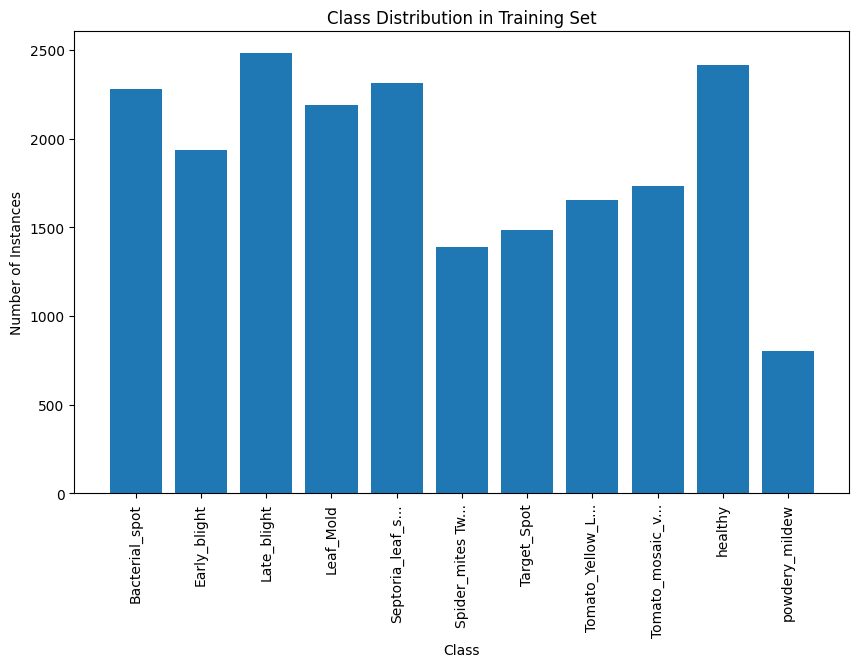

In [ ]:
y_true = training_set.classes  # Class labels from the training set

# Calculate the unique class labels and their counts
unique, counts = np.unique(y_true, return_counts=True)

max_label_length = 15

truncated_labels = [label[:max_label_length] + '...' if len(label) > max_label_length else label for label in label_map.keys()]

# Plot the class distribution
plt.figure(figsize=(10, 6))
plt.bar(unique, counts, tick_label=truncated_labels)
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.xticks(rotation=90)
plt.show()

### Testing Distribution

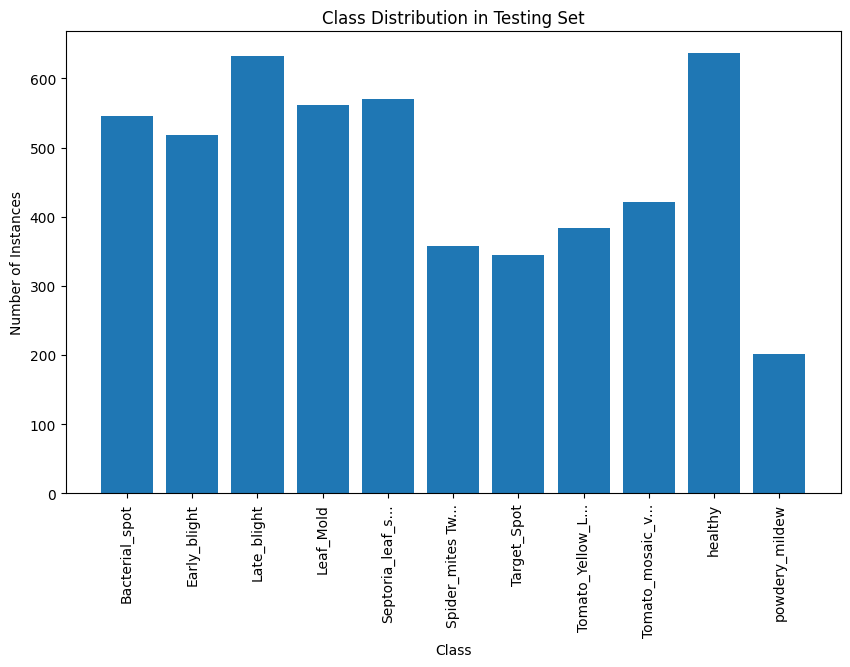

In [ ]:
y_true = testing_set.classes  # Class labels from the testing set

# Calculate the unique class labels and their counts
unique, counts = np.unique(y_true, return_counts=True)

max_label_length = 15

# Truncate the labels if they exceed the maximum length
truncated_labels = [label[:max_label_length] + '...' if len(label) > max_label_length else label for label in label_map.keys()]

# Plot the class distribution
plt.figure(figsize=(10, 6))
plt.bar(unique, counts, tick_label=truncated_labels)
plt.title('Class Distribution in Testing Set')
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.xticks(rotation=90)
plt.show()

### Validation Distribution

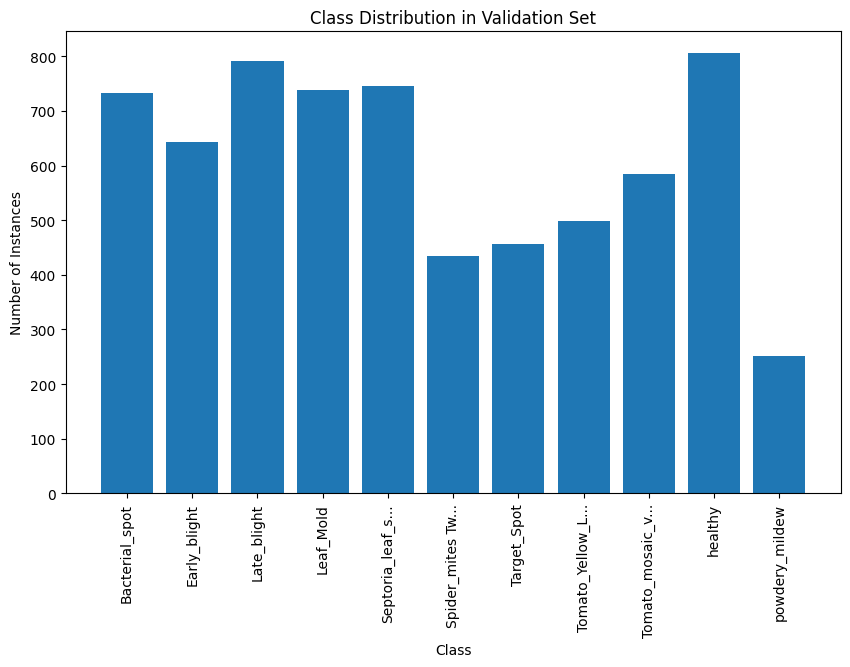

In [ ]:
y_true = validation_set.classes  # Class labels from the validation set

# Calculate the unique class labels and their counts
unique, counts = np.unique(y_true, return_counts=True)

max_label_length = 15

# Truncate the labels if they exceed the maximum length
truncated_labels = [label[:max_label_length] + '...' if len(label) > max_label_length else label for label in label_map.keys()]

# Plot the class distribution
plt.figure(figsize=(10, 6))
plt.bar(unique, counts, tick_label=truncated_labels)
plt.title('Class Distribution in Validation Set')
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.xticks(rotation=90)
plt.show()

### Combined Distribution

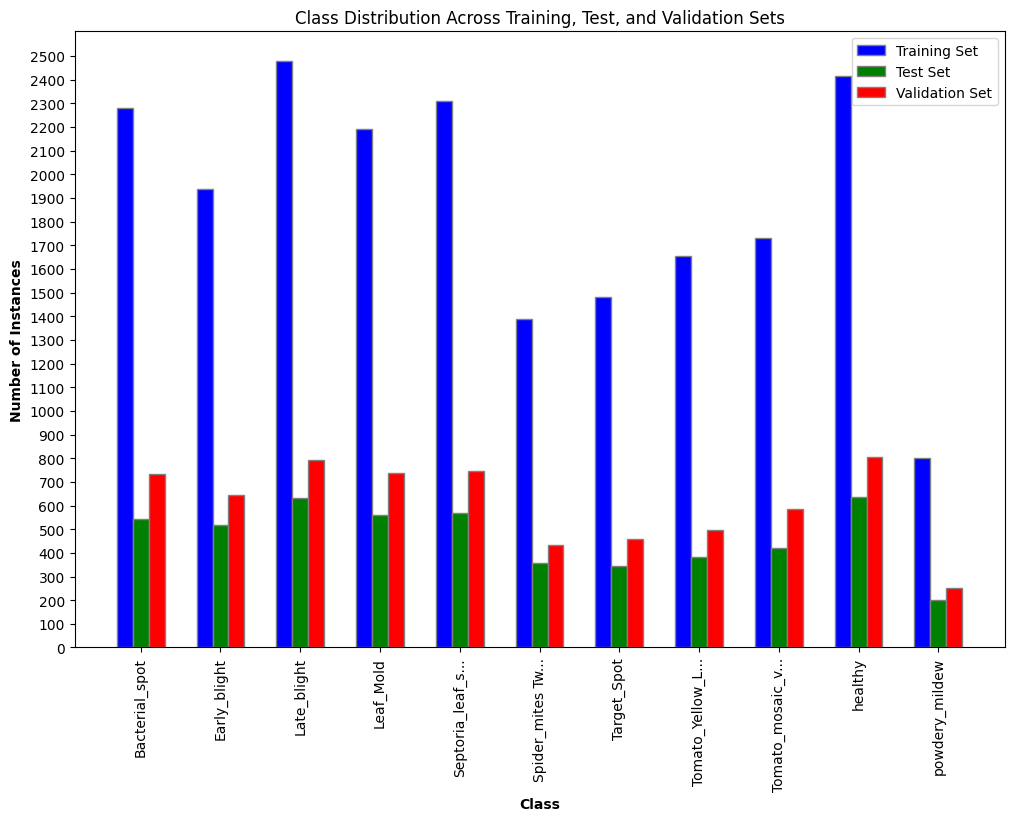

In [ ]:
y_train = training_set.classes  # Class labels from the training set generator
y_test = testing_set.classes    # Class labels from the test set generator
y_val = validation_set.classes  # Class labels from the validation set generator

# Label map is the same for all sets
label_map = training_set.class_indices

# Calculate the unique class labels and their counts for each dataset
unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)
unique_val, counts_val = np.unique(y_val, return_counts=True)


max_label_length = 15
truncated_labels = [label[:max_label_length] + '...' if len(label) > max_label_length else label for label in label_map.keys()]

# Create the bar positions for each dataset
bar_width = 0.2
r1 = np.arange(len(unique_train))  # Positions of bars for the training set
r2 = [x + bar_width for x in r1]   # Positions of bars for the test set
r3 = [x + bar_width for x in r2]   # Positions of bars for the validation set

# Plot the grouped bar chart
plt.figure(figsize=(12, 8))
plt.bar(r1, counts_train, color='blue', width=bar_width, edgecolor='grey', label='Training Set')
plt.bar(r2, counts_test, color='green', width=bar_width, edgecolor='grey', label='Test Set')
plt.bar(r3, counts_val, color='red', width=bar_width, edgecolor='grey', label='Validation Set')

plt.xlabel('Class', fontweight='bold')
plt.ylabel('Number of Instances', fontweight='bold')
plt.title('Class Distribution Across Training, Test, and Validation Sets')

# Add x-ticks on the middle of the group bars
plt.xticks([r + bar_width for r in range(len(unique_train))], truncated_labels, rotation=90)

plt.yticks(np.arange(0, max(max(counts_train), max(counts_test), max(counts_val)) + 100, step=100))

plt.legend()
plt.show()

# Modeling

## Imports

In [ ]:
import tensorflow
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import EfficientNetB0


## Build & Compile Model

In [ ]:
# Load the EfficientNetB0 model
convolution_base = EfficientNetB0(
    weights='imagenet',
    include_top=False,  # Excludes the top layer
    input_shape=(256, 256, 3),
    pooling='max'
)

print(convolution_base.summary())
x = convolution_base.output
x = BatchNormalization()(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(0.40)(x)
x = Dense(units=11, activation='softmax')(x)  # Output layer (11 Possible Classes)
model = Model(inputs=convolution_base.input,outputs=x)

model.compile(optimizer=Adamax(learning_rate=0.001),
                   loss='categorical_crossentropy',
                   metrics=['accuracy']
)

print(model.summary()) # Displays Model Structure


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 256, 256, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 256, 256, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 256, 256, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 257, 257, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 128, 128, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 128, 128, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 128, 128, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 128, 128, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 128, 128, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 128, 128, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 4,007,548 (15.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

None


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 256, 256, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 256, 256, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 256, 256, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 257, 257, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 128, 128, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 128, 128, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 128, 128, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 128, 128, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 128, 128, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 128, 128, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,220,078 (16.10 MB)

 Trainable params: 4,175,495 (15.93 MB)

 Non-trainable params: 44,583 (174.16 KB)

None


## Train Model

In [ ]:
history = model.fit(
        training_set,
        epochs=20,
        validation_data=validation_set,
        callbacks=[EarlyStopping(patience=3)] # Stops if Val Loss doesnt improve after three epochs (Prevent Overfitting)
)

print(model.summary()) # Displays Model Structure

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


647/647 ━━━━━━━━━━━━━━━━━━━━ 207s 201ms/step - accuracy: 0.6926 - loss: 0.9850 - val_accuracy: 0.4221 - val_loss: 2.6542
Epoch 2/20
647/647 ━━━━━━━━━━━━━━━━━━━━ 78s 119ms/step - accuracy: 0.9261 - loss: 0.2234 - val_accuracy: 0.9545 - val_loss: 0.1341
Epoch 3/20
647/647 ━━━━━━━━━━━━━━━━━━━━ 77s 119ms/step - accuracy: 0.9552 - loss: 0.1308 - val_accuracy: 0.9702 - val_loss: 0.1060
Epoch 4/20
647/647 ━━━━━━━━━━━━━━━━━━━━ 77s 118ms/step - accuracy: 0.9715 - loss: 0.0873 - val_accuracy: 0.9746 - val_loss: 0.0971
Epoch 5/20
647/647 ━━━━━━━━━━━━━━━━━━━━ 77s 119ms/step - accuracy: 0.9784 - loss: 0.0629 - val_accuracy: 0.9826 - val_loss: 0.0781
Epoch 6/20
647/647 ━━━━━━━━━━━━━━━━━━━━ 78s 119ms/step - accuracy: 0.9847 - loss: 0.0437 - val_accuracy: 0.9828 - val_loss: 0.0837
Epoch 7/20
647/647 ━━━━━━━━━━━━━━━━━━━━ 78s 120ms/step - accuracy: 0.9886 - loss: 0.0377 - val_accuracy: 0.9837 - val_loss: 0.0736
Epoch 8/20
647/647 ━━━━━━━━━━━━━━━━━━━━ 77s 119ms/step - accuracy: 0.9893 - loss: 0.0315 - va

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 256, 256, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 256, 256, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 256, 256, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 257, 257, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 128, 128, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 128, 128, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 128, 128, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 128, 128, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 128, 128, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 128, 128, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 12,571,070 (47.95 MB)

 Trainable params: 4,175,495 (15.93 MB)

 Non-trainable params: 44,583 (174.16 KB)

 Optimizer params: 8,350,992 (31.86 MB)

None


## Save & Download Model

In [ ]:
# Save the model for Web Application
model.save('tomato_disease_model.h5')
print('Saved trained model as tomato_disease_model.h5')

#Download the model for Web Application
from google.colab import files
files.download('tomato_disease_model.h5')

Saved trained model as tomato_disease_model.h5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Save & Download Training History

In [ ]:
import json

# Convert the history.history dict to JSON
history_json = json.dumps(history.history)

# Write the JSON data to a file
with open('model_history.json', 'w') as json_file:
    json_file.write(history_json)

files.download('model_history.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Evaluating the Model

## Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Training Loss & Accuracy

In [ ]:
evaluation = model.evaluate(training_set)
print(f"Training Loss: {evaluation[0]}")
print(f"Training Accuracy: {evaluation[1]}")

647/647 ━━━━━━━━━━━━━━━━━━━━ 47s 72ms/step - accuracy: 0.9996 - loss: 0.0015
Training Loss: 0.0011500734835863113
Training Accuracy: 0.9996615052223206


## Test Loss & Accuracy

In [ ]:
evaluation = model.evaluate(testing_set)
print(f"Test Loss: {evaluation[0]}")
print(f"Test Accuracy: {evaluation[1]}")

  2/162 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.9922 - loss: 0.0190      

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


162/162 ━━━━━━━━━━━━━━━━━━━━ 19s 114ms/step - accuracy: 0.9869 - loss: 0.0624
Test Loss: 0.06208047270774841
Test Accuracy: 0.9876232743263245


## Learning Curve


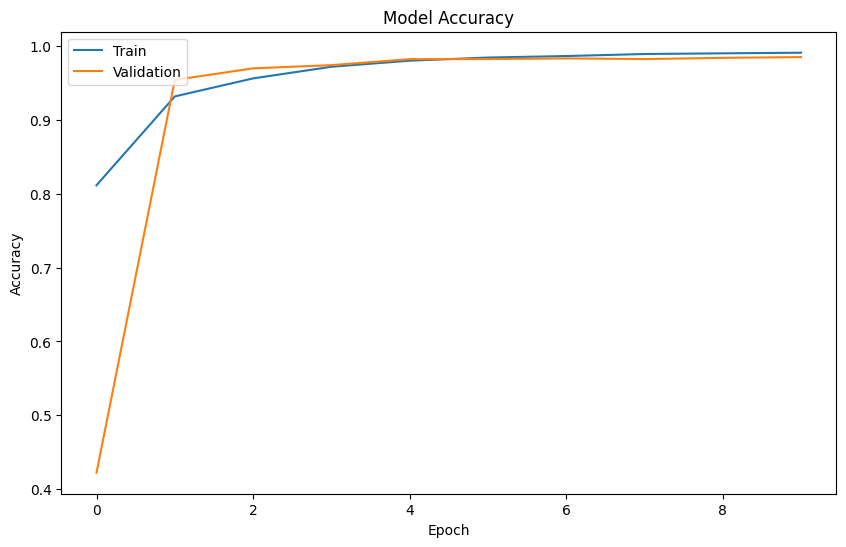

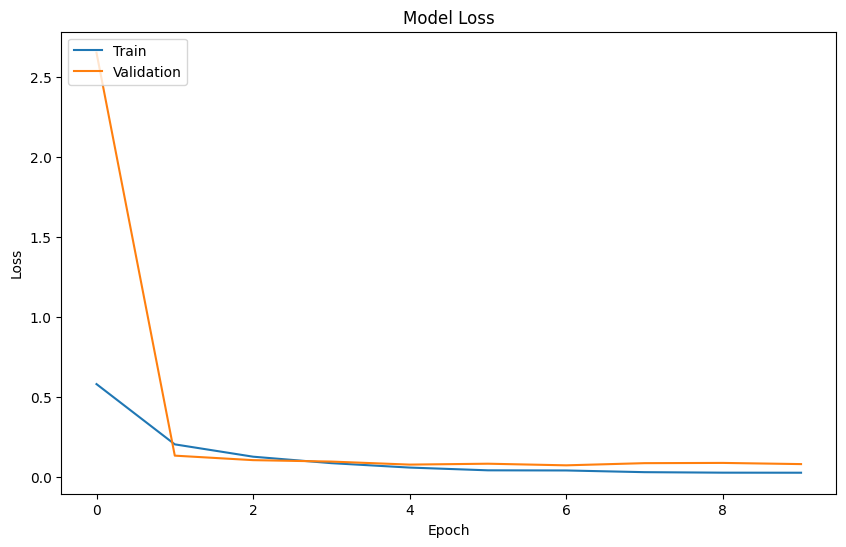

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Confusion Matrix

162/162 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step


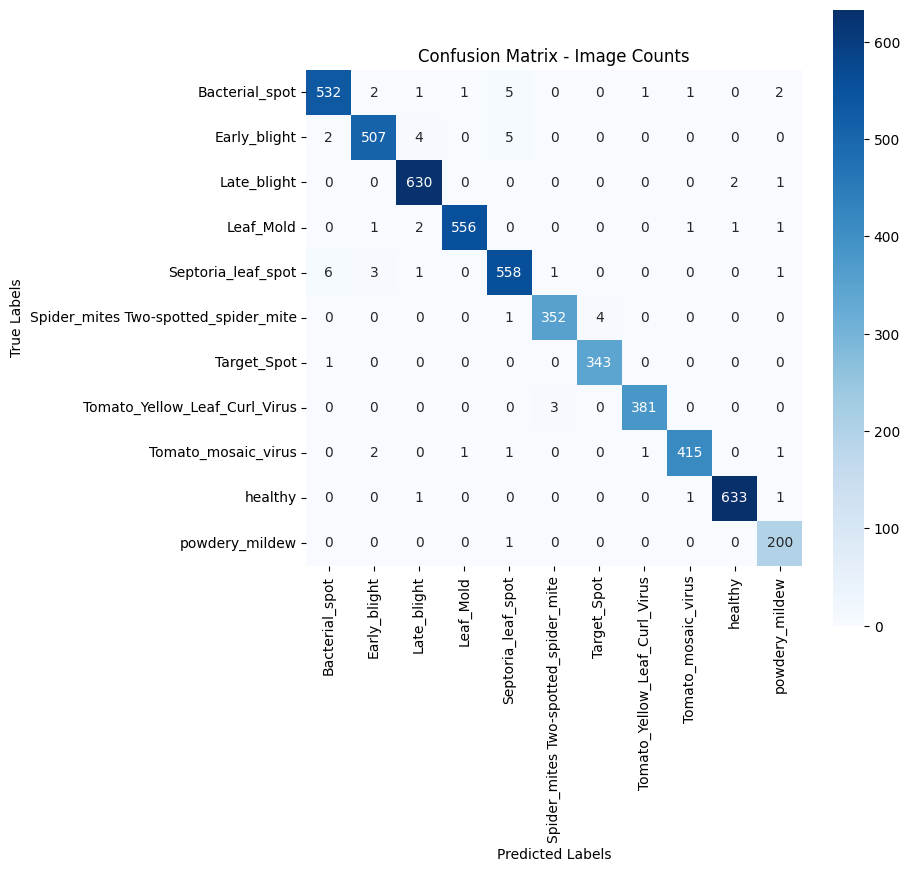

In [ ]:
from sklearn.metrics import confusion_matrix

# Predict the classes for the entire test set
testing_set.reset()  # Reset the generator to ensure it goes through all data
label_map = testing_set.class_indices

y_true = testing_set.classes  # Actual class labels
y_pred = model.predict(testing_set)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class indices

max_label_length = 15
truncated_labels = [label[:max_label_length] + '...' if len(label) > max_label_length else label for label in label_map.keys()]

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plotting the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True, xticklabels=truncated_labels, yticklabels=truncated_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Image Counts')
plt.show()

## Classification Report

In [ ]:
from sklearn.metrics import classification_report

# Print classification report
print(classification_report(y_true, y_pred_classes, target_names=list(label_map.keys())))

                                      precision    recall  f1-score   support

                      Bacterial_spot       0.98      0.98      0.98       545
                        Early_blight       0.98      0.98      0.98       518
                         Late_blight       0.99      1.00      0.99       633
                           Leaf_Mold       1.00      0.99      0.99       562
                  Septoria_leaf_spot       0.98      0.98      0.98       570
Spider_mites Two-spotted_spider_mite       0.99      0.99      0.99       357
                         Target_Spot       0.99      1.00      0.99       344
       Tomato_Yellow_Leaf_Curl_Virus       0.99      0.99      0.99       384
                 Tomato_mosaic_virus       0.99      0.99      0.99       421
                             healthy       1.00      1.00      1.00       636
                      powdery_mildew       0.97      1.00      0.98       201

                            accuracy                          